In [3]:
%pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


In [29]:
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

import matplotlib.pyplot as plt
import math

In [2]:
# !unzip "./svm/drive/MyDrive/svm.zip"

In [3]:
# %pip install opencv-python
import cv2 as cv2 
import numpy as np
import os

In [4]:
def resize(img_name, new_size):
  img = cv2.imread(img_name)
  img = img.astype(np.float32)
  img = cv2.resize(img,  new_size)
  norm_img = img/255.0
  norm_img = norm_img.flatten()

  return norm_img

In [50]:
# design matrix
folder_name = "./svm/train/3"

X = tuple()
new_shape = (16, 16)
cnt = 2

for filename in os.listdir(folder_name):
      file = os.path.join(folder_name, filename)
      Y = resize(file, new_shape)
      X = X + ( Y[None , ...], )


folder_name = "./svm/train/1"
for filename in os.listdir(folder_name):
      file = os.path.join(folder_name, filename)
      Y = resize(file, new_shape)
      X = X + ( Y[None , ...], )

X = np.vstack(X)


In [38]:
# labels
Y = np.array([], dtype = int)
for i in range( int(X.shape[0]/2) ):
  Y = np.append(Y, -1)
for i in range(int(X.shape[0]/2)):
  Y = np.append(Y, 1)



In [7]:
print(X.shape)
print(Y)
temp = np.array([[1,2,3], [1,2,3],[4,5,6]])
temp3 = temp ** 2 
print(temp)

(4760, 768)
[-1 -1 -1 ...  1  1  1]
[[1 2 3]
 [1 2 3]
 [4 5 6]]


In [45]:
# modelling the problem as a cvx opt problem

class SVM:
  def __init__(self, X, Y, C):
    self.X = X
    self.Y = Y
    self.C = C
    self.m = Y.shape[0]
    print("here")
    self.P = matrix(self.get_P())
    self.q = matrix(np.full( (self.m, ), -1 ))

    temp = np.full( (self.m, ) , 1)
    temp2 = np.full( (self.m, ) , -1)
    self.G = matrix(np.vstack( ( np.diag(temp2), np.diag(temp))  ) )

    temp = np.full( (self.m, ), C)
    self.h = matrix(np.hstack( ( np.zeros( (self.m, ) ), temp) ) )

    self.A = matrix(np.vstack( (self.Y, )))
    self.b = matrix(np.zeros( (1,) ))

    self.P = matrix( np.array(self.P), tc='d')
    self.q = matrix( np.array(self.q), tc='d')
    self.G = matrix( np.array(self.G), tc='d')
    self.h = matrix( np.array(self.h), tc='d')
    self.A = matrix( np.array(self.A), tc='d')
    self.b = matrix( np.array(self.b), tc='d')
    self.no_of_classes = 2

    self.soln = None


  def kernel(self, x, y):
    return (x.T) @ y # override for different kernels


  def gaussian_kernel_matrix(self): # custom functoin for gaussian kernel
    
    pairwise_sq_dists = np.sum(self.X**2 , axis=1, keepdims=True) - 2 * np.dot(self.X, self.X.T) + np.sum(self.X**2, axis=1, keepdims=True).T
    self.kernel_matrix = np.exp(- self.gamma * pairwise_sq_dists)
    print(np.outer(self.Y, self.Y).shape) 
    self.kernel_matrix = np.outer(self.Y, self.Y) * self.kernel_matrix 
    
    # self.inner_product_matrix = self.X @ (self.X).T
    # print(self.inner_product_matrix.shape)
    # self.kernel_matrix = np.zeros(self.inner_product_matrix.shape) 
    # for i in range(self.m):
    #   for j in range(self.m):
    #     self.kernel_matrix[i, j] = ( -self.gamma * (self.inner_product_matrix[i, i] + self.inner_product_matrix[j, j] - 2 * self.inner_product_matrix[i, j] ) )
    # self.kernel_matrix = np.exp(self.kernel_matrix) 
    return 
   

  def get_P(self):
    new_shape = (self.m , self.m)
    temp = np.zeros(new_shape)
    for i in range(self.m):
      for j in range(self.m):
        temp[i, j] = self.Y[i] * self.Y[j] * self.kernel(self.X[i, :], self.X[j, :])
    return temp

  def solve(self):
    self.soln = solvers.qp(self.P, self.q, self.G, self.h, self.A, self.b)
    return self.soln

  def get_support_vectors(self):
    alphas = np.array(self.soln["x"])
    alphas = np.array( [ alpha[0] for alpha in alphas] )
    # print(alphas)
    alphas = [[alphas[i],  int(i) ] for i in range(alphas.shape[0])]
    alphas = np.array(alphas)
    self.og_alphas = alphas
    sorted_indices = np.argsort(self.og_alphas[:, 1])
    self.og_alphas = self.og_alphas[sorted_indices]
    shape = alphas.shape
    m = shape[0]

    self.init_size = alphas.shape[0]
    support_vectors = np.array([ (alpha[0], alpha[1]) for alpha in alphas if (alpha[0] > 1e-05)] )
    sorted_indices = np.argsort(support_vectors[:, 0])
    self.support_vectors = support_vectors[sorted_indices]
    self.no_of_support_vectors = support_vectors.shape[0]
    print(self.init_size, self.no_of_support_vectors)
    return (self.og_alphas, self.support_vectors)

  def inner_product(self, x): # takes inner product of a input attribute' feature vector with weight vector
    temp = np.array([self.kernel(self.X[i], x) for i in range(self.m)])
    return np.sum(self.og_alphas[:,0] * self.Y * temp)

  def get_weight(self): # only valid for linear kernel, not gaussian kernel
    weight = np.zeros( (self.Y.shape[0], ) )
    temp = self.Y * (self.og_alphas[:,0])
    self.weight = ( (self.X).T @ temp)
    # weight = np.sum ( temp2,axis = 0)
    print(weight.shape)
    return self.weight

  def get_bias(self):
      # m = (self.og_alphas).shape[0]
      all_bias = []
      for i in range(self.m):
        alpha = self.og_alphas[i,0]
        if (alpha < 1e-05 or (self.C - alpha) < 1e-05): continue
        # temp = ((self.weight.T) @ self.X[i])
        temp = self.inner_product(self.X[i])
        bias = self.Y[i] - temp
        all_bias.append(bias)
      all_bias = np.array(all_bias)
      self.bias = np.sum(all_bias)/all_bias.shape[0]
      return self.bias

  def predict(self, example):
    temp = self.inner_product(example) + self.bias
    # print(temp)
    if (temp > 0) : predict = 1
    else: predict = -1
    return (predict, temp)

  def get_confusion_matrix(self, test_eg, test_ans) :
    size = test_eg.shape[0]
    confusion_matrix = np.zeros( (self.no_of_classes, self.no_of_classes))
    correct , incorrect = 0,0
    for k in range(size):
      (prediction, score) = self.predict(test_eg[k])
      if (test_ans[k] == prediction) : correct += 1
      else : incorrect +=  1

      if (prediction == -1) : prediction = 0
      copy = 1
      if (test_ans[k] == -1) : copy = 0
      confusion_matrix[copy][prediction] += 1


    return (confusion_matrix, (correct / (correct + incorrect)))




In [39]:
linear_kernel = SVM(X, Y , 1.0)

here


In [21]:
soln = linear_kernel.solve()

     pcost       dcost       gap    pres   dres
 0: -3.0954e+03 -1.5799e+04  9e+04  4e+00  1e-10
 1: -2.1202e+03 -1.2138e+04  2e+04  6e-01  8e-11
 2: -1.9840e+03 -4.6258e+03  3e+03  2e-12  7e-11
 3: -2.3242e+03 -3.0811e+03  8e+02  1e-12  6e-11
 4: -2.4551e+03 -2.8440e+03  4e+02  6e-14  7e-11
 5: -2.5320e+03 -2.7012e+03  2e+02  2e-13  7e-11
 6: -2.5690e+03 -2.6351e+03  7e+01  8e-13  7e-11
 7: -2.5858e+03 -2.6069e+03  2e+01  1e-12  8e-11
 8: -2.5910e+03 -2.5987e+03  8e+00  9e-13  7e-11
 9: -2.5935e+03 -2.5952e+03  2e+00  3e-13  8e-11
10: -2.5941e+03 -2.5943e+03  2e-01  1e-12  8e-11
11: -2.5942e+03 -2.5942e+03  1e-02  3e-12  8e-11
12: -2.5942e+03 -2.5942e+03  3e-04  2e-12  8e-11
Optimal solution found.


In [22]:
# linear_kernel.get_support_vectors()
# print(soln["x"])
# og_alphas, support_vectors = get_support_vectors(soln)
og_alphas, support_vectors = linear_kernel.get_support_vectors()
print(support_vectors)


4760 2904
[[1.06765294e-05 1.38800000e+03]
 [8.48969638e-05 4.22900000e+03]
 [9.51915758e-05 2.59600000e+03]
 ...
 [9.99999995e-01 4.69800000e+03]
 [9.99999995e-01 2.22100000e+03]
 [9.99999996e-01 1.15200000e+03]]


In [23]:
# weight = get_weight(og_alphas, X, Y)
weight = linear_kernel.get_weight()
print(weight.shape)

(4760,)
(768,)


Weight vector is printed above

In [24]:
print(og_alphas)


[[9.99999987e-01 0.00000000e+00]
 [3.12992327e-08 1.00000000e+00]
 [1.46060173e-08 2.00000000e+00]
 ...
 [9.99999980e-01 4.75700000e+03]
 [6.49466639e-01 4.75800000e+03]
 [9.05839078e-01 4.75900000e+03]]


In [25]:
# bias = get_bias(og_alphas, X, Y, weight, 1.0)
bias = linear_kernel.get_bias()
print(bias)
# bias =

0.7250441038827395


Bias is 0.725

We get 2903 support vectors out of 4760 training examples. We take a margin of 1e0-5 for values of alpha.
The percentage of suport vectors is 60.99 %

In [42]:
# validation matrix
folder_name = "./svm/val/0"


new_shape = (16, 16)

validation_eg = []
answers = []
correct , incorrect = 0,0
for filename in os.listdir(folder_name):
      answers.append(-1)
      file = os.path.join(folder_name, filename)
      temp = resize(file, new_shape)
      validation_eg.append(temp)

folder_name = "./svm/val/1"
for filename in os.listdir(folder_name):
      answers.append(1)
      file = os.path.join(folder_name, filename)
      temp = resize(file, new_shape)
      validation_eg.append(temp)

validation_eg = np.array(validation_eg)
answers = np.array(answers)

# X = np.vstack(X)



In [2]:
( confusion_matrix, accuracy) = linear_kernel.get_confusion_matrix(validation_eg, answers)
print(f"accuracy is {accuracy}")

NameError: name 'linear_kernel' is not defined

We get validation accuracy as 72.75 %

In [11]:
class Gaussian_Kernel(SVM):
   def __init__(self, X, Y, C, gamma):
      self.X = X
      self.Y = Y
      self.C = C
      self.m = Y.shape[0]
      self.gamma = gamma
      print("here in gaussian")
      self.gaussian_kernel_matrix()
      # print(self.kernel_matrix) 
      self.P = matrix(self.kernel_matrix)
      self.q = matrix(np.full( (self.m, ), -1 ))

      temp = np.full( (self.m, ) , 1)
      temp2 = np.full( (self.m, ) , -1)
      self.G = matrix(np.vstack( ( np.diag(temp2), np.diag(temp))  ) )

      temp = np.full( (self.m, ), C)
      self.h = matrix(np.hstack( ( np.zeros( (self.m, ) ), temp) ) )

      self.A = matrix(np.vstack( (self.Y, )))
      self.b = matrix(np.zeros( (1,) ))

      self.P = matrix( np.array(self.P), tc='d')
      self.q = matrix( np.array(self.q), tc='d')
      self.G = matrix( np.array(self.G), tc='d')
      self.h = matrix( np.array(self.h), tc='d')
      self.A = matrix( np.array(self.A), tc='d')
      self.b = matrix( np.array(self.b), tc='d')

      self.soln = None
      self.no_of_classes = 2


   def kernel(self, x, y):
    #  temp = x - y
     norm_sq = (x - y).T @ (x - y)
     return math.exp(-self.gamma * norm_sq)
   
   




In [12]:
C = 1.0
gamma = 0.001
gaussian_kernel = Gaussian_Kernel(X, Y, C, gamma)

here in gaussian
(4760, 4760)


In [15]:
soln2 = gaussian_kernel.solve()

     pcost       dcost       gap    pres   dres
 0: -3.4913e+03 -1.3865e+04  6e+04  3e+00  4e-13
 1: -2.4344e+03 -1.0060e+04  1e+04  2e-01  4e-13
 2: -2.6495e+03 -3.7863e+03  1e+03  2e-02  4e-13
 3: -3.0481e+03 -3.3180e+03  3e+02  4e-03  4e-13
 4: -3.1344e+03 -3.2403e+03  1e+02  1e-03  4e-13
 5: -3.1708e+03 -3.2049e+03  3e+01  3e-04  4e-13
 6: -3.1840e+03 -3.1918e+03  8e+00  6e-05  4e-13
 7: -3.1875e+03 -3.1883e+03  8e-01  4e-06  5e-13
 8: -3.1879e+03 -3.1879e+03  4e-02  2e-07  5e-13
 9: -3.1879e+03 -3.1879e+03  3e-03  1e-08  5e-13
Optimal solution found.


In [121]:
gaussian_kernel.get_support_vectors()
gaussian_kernel.get_bias()

4760 3453


-2.784077251037924

In [122]:
(confusion_matrix, accuracy) = gaussian_kernel.get_confusion_matrix(validation_eg, answers)
print(f"accuracy is {accuracy}")

accuracy is 0.7775


Gaussian kernel has accuracy

In [36]:
# plotting images
def plot(svm, svm_name, flag = True ):
  top_6 = svm.support_vectors[-6:]

  # print(top_6)
  top_6 = np.array([ (svm.X[ int(sv[1]) ]) * 255.0 for sv in top_6])
  top_6 = np.array([ img.reshape((16,16,3)) for img in top_6])
  cnt = 0
  for img in top_6:

    cnt += 1
    cv2.imwrite(f"img_{cnt}_{svm_name}.png", img)

  if (flag):
    resized_weight = weight * 255.0
    resized_weight = resized_weight.reshape( (16, 16, 3) )
    cv2.imwrite(f"weight_{svm_name}.png", resized_weight)

def get_common_support_vectors(svm1, svm2):
    v1 = set( svm1.support_vectors[:, 1] )
    v2 = set( svm2.support_vectors[:, 1]   )
    print(f"lens are {len(v1)} and {len(v2)}")
    common = v1 & v2 # intersection of two sets
    return len(common)



In [ ]:
plot(linear_kernel, "Linear")
plot(gaussian_kernel, "Gaussian", False)
print(get_common_support_vectors(linear_kernel, gaussian_kernel))


Linear kernel had 2903 (60.99 %) support vectors, and Gaussian has 3453 (72.54 %) support vectors. The common support vectors are 2698 (56.68 %) in count.

Validation accuracy for Gaussian is 77.75 % (compared to 72.75 % for linear kernel, an increase of 5 %) .

In [28]:
# !pip install scikit
from sklearn import svm

In [43]:
sk_linear_kernel = svm.SVC(C = 1.0, kernel = "linear")
sk_linear_kernel.fit(X, Y)

SVC(kernel='linear')

In [44]:
predictions = sk_linear_kernel.predict(validation_eg)
correct , incorrect = 0,0

# print(predictions.shape[0])

for i in range(predictions.shape[0]):
  if (predictions[i] == answers[i]): correct += 1
  else : incorrect += 1

print(f"Correct : {correct}")
print(f"Incorrect : {incorrect}")
print(f"accuracy : {correct / (correct + incorrect)}")


Correct : 336
Incorrect : 64
accuracy : 0.84


In [40]:
sk_gaussian_kernel = svm.SVC(C = 1.0, kernel = "rbf", gamma = 0.001)
sk_gaussian_kernel.fit(X, Y)


SVC(gamma=0.001)

In [41]:
predictions = sk_gaussian_kernel.predict(validation_eg)
correct , incorrect = 0,0

# print(predictions.shape[0])

for i in range(predictions.shape[0]):
  if (predictions[i] == answers[i]): correct += 1
  else : incorrect += 1

print(f"Correct : {correct}")
print(f"Incorrect : {incorrect}")
print(f"accuracy : {correct / (correct + incorrect)}")

Correct : 311
Incorrect : 89
accuracy : 0.7775


As can be observed, the accuracy obtained from the scikit learn SVM function is exactly the same as obtained from our implementation. Hence our model has been implemented correctly.

In [ ]:
linear_sv = sk_linear_kernel.support_
gaussian_sv = sk_gaussian_kernel.support_
# print(linear_sv)
sk_set1 = set(linear_sv)
sk_set2 = set(gaussian_sv)
set1 = set( linear_kernel.support_vectors[:, 1] )
set2 = set( gaussian_kernel.support_vectors[:, 1]   )

print(f"no of support vectors for sklearn linear svm is {len(sk_set1)}")
print(f"no of support vectors for sklearn gaussian svm is {len(sk_set2)}")
print(f"no of support vectors for  linear svm is {len(set1)}")
print(f"no of support vectors for  gaussian svm is {len(set2)}")

print(f"no of support vectors common for linear svm are {len(sk_set1 & set1)}")
print(f"no of support vectors common for gaussian svm is {len(sk_set2 & set2)}")


no of support vectors for sklearn linear svm is 2899

no of support vectors for sklearn gaussian svm is 3398

no of support vectors for  linear svm is 2903

no of support vectors for  gaussian svm is 3453

no of support vectors common for linear svm are 2899

no of support vectors common for gaussian svm is 3398

From the numbers we conclude that the sv used in both of our implmented models are also used by the corresponding sklearn models, along with a few additional sv.

In [ ]:
sk_weight = sk_linear_kernel.coef_
sk_bias = sk_linear_kernel.intercept_

og_weight = linear_kernel.get_weight()
og_bias = linear_kernel.get_bias()

In [ ]:
# print(f"weight obtained for sklearn linear svm is {sk_weight}")
print(f"bias obtained for sklearn linear svm is {sk_bias}")

# print(f"weight obtained for  linear svm is {og_weight}")
print(f"bias obtained for  linear svm is {og_bias}")


In [ ]:
temp = (sk_weight[0] - og_weight )
norm_sk = sk_weight[0].T @ sk_weight[0]
norm = temp.T @ temp
print(math.sqrt(norm/norm_sk) * 100 )

bias obtained for sklearn linear svm is 0.7251
bias obtained for  linear svm is 0.7251

The biases obtained are identical, the weight vectors are also almost identical, the rms error being 0.247 %

In [ ]:
time_1 = 149 + 134
time_2 = 272 + 114
time_3 = 12
time_4 = 7
print(f"time taken by our linear svm is {time_1} sec")
print(f"time taken by our gaussian svm is {time_2} sec")
print(f"time taken by sklearn linear svm is {time_3} sec")
print(f"time taken by sklearn gaussian svm is {time_4} sec")

time taken by our linear svm is 283 sec

time taken by our gaussian svm is 386 sec

time taken by sklearn linear svm is 12 sec

time taken by sklearn gaussian svm is 7 sec

Hence there is quite a reduction in the training time when using sklearn !!

In [51]:

class Multi_Class_SVM:
  def __init__(self, X, Y, k, C, gamma):
    self.m = X.shape[0]
    # print(self.m)
    self.X = X
    self.Y = Y
    self.no_of_classes = k
    self.training_datasets = self.split_dataset()
    self.C = C
    self.gamma = gamma


  def split_dataset(self):
    temp = [[] for i in range(self.no_of_classes)]
    # print(temp)
    for i in range(self.m):
      (temp[self.Y[i]]).append(self.X[i])

    return np.array(temp)


  def train(self):
    self.model = np.full((self.no_of_classes, self.no_of_classes), None, dtype=object)
    for i in range(self.no_of_classes):
      for j in range(self.no_of_classes):
        if (i == j or self.model[i,j] != None): continue
        print(f"training being done for classes {i} and {j}")
        X_ij = np.vstack( ( np.array(self.training_datasets[i]), np.array(self.training_datasets[j]) )  )
        size1 = len(self.training_datasets[i])
        size2 = len(self.training_datasets[j])
        Y_ij = np.zeros( size1 + size2 )
        for k in range(size1 ):
          Y_ij[k] = -1
        for k in range(size1, size1 + size2):
          Y_ij[k] = 1
        print(X_ij.shape, Y_ij.shape)
        self.model[i,j] = Gaussian_Kernel(X_ij, Y_ij, self.C, self.gamma)
        print("invoking solver now") 
        (self.model[i,j]).solve()
        print("solved")
        (self.model[i,j]).get_support_vectors()
        (self.model[i,j]).get_bias()
        self.model[j, i] = self.model[i,j]
    print("training complete")

  def predict(self, eg):
    scores = np.zeros( (self.no_of_classes, ))
    counts =  np.zeros( (self.no_of_classes, ))
    done = np.zeros((self.no_of_classes, self.no_of_classes))
    for i in range(self.no_of_classes):
      for j in range(self.no_of_classes):
        if (i == j or done[i][j] == 1) : continue
        done[i][j] = 1
        done[j][i] = 1
        # i is -1, j is one
        (prediction, score) = self.model[i,j].predict(eg)
        if (prediction == -1) : prediction = i
        else : prediction = j
        counts[prediction] += 1
        if (score > 0) : scores[prediction] += score
        else: scores[prediction] -= score

    max_count = np.max(counts)
    max_indices = np.where(counts == max_count)[0]
    max_scores = np.array([(scores[i], i) for i in max_indices])
    max_scores.sort()
    return (max_scores[-1, 1], max_scores[-1, 0])

  def get_confusion_matrix(self, test_eg, test_ans) :
    size = test_eg.shape[0]
    confusion_matrix = np.zeros( (self.no_of_classes, self.no_of_classes))
    correct , incorrect = 0,0
    for k in range(size):
      (prediction, score) = self.predict(test_eg[k])
      print(prediction, "\n", test_ans[k]) 
      confusion_matrix[test_ans[k]][prediction] += 1
      if (test_ans[k] == prediction) : correct += 1
      else : incorrect +=  1

    return (confusion_matrix, (correct / (correct + incorrect)))


In [24]:
# design matrix
folder_name = "./svm/train/"
no_of_classes = 6
classes = [i for i in range(no_of_classes)]
X_full = tuple()
new_shape = (16, 16)
Y_full = np.array([], dtype = int)
for label in classes:
  for filename in os.listdir(f"{folder_name}{label}"):
        file = os.path.join(f"{folder_name}{label}", filename)
        Z = resize(file, new_shape)
        X_full = X_full + ( Z[None , ...], )
        Y_full = np.append(Y_full, label)

X_full = np.vstack(X_full)



In [25]:
C = 1.0
gamma = 0.001
multiclass_classifier = Multi_Class_SVM(X_full, Y_full, no_of_classes, C, gamma)


In [26]:
multiclass_classifier.train()

training being done for classes 0 and 1
(4760, 768) (4760,)
here in gaussian
(4760, 4760)
invoking solver now
     pcost       dcost       gap    pres   dres
 0: -1.9395e+03 -1.4694e+04  9e+04  4e+00  2e-13
 1: -1.2732e+03 -1.0479e+04  2e+04  4e-01  3e-13
 2: -1.1848e+03 -2.6736e+03  1e+03  1e-12  2e-13
 3: -1.4359e+03 -2.1033e+03  7e+02  1e-12  2e-13
 4: -1.5028e+03 -1.9941e+03  5e+02  1e-12  2e-13
 5: -1.5739e+03 -1.8706e+03  3e+02  7e-13  2e-13
 6: -1.6195e+03 -1.7957e+03  2e+02  3e-13  2e-13
 7: -1.6451e+03 -1.7555e+03  1e+02  5e-13  2e-13
 8: -1.6663e+03 -1.7227e+03  6e+01  8e-13  2e-13
 9: -1.6772e+03 -1.7069e+03  3e+01  1e-12  2e-13
10: -1.6859e+03 -1.6950e+03  9e+00  1e-12  2e-13
11: -1.6891e+03 -1.6907e+03  2e+00  7e-14  3e-13
12: -1.6898e+03 -1.6899e+03  6e-02  1e-13  3e-13
13: -1.6898e+03 -1.6898e+03  2e-03  1e-12  3e-13
14: -1.6898e+03 -1.6898e+03  3e-05  3e-14  3e-13
Optimal solution found.
solved
4760 1959
training being done for classes 0 and 2
(4760, 768) (4760,)
here i

In [68]:

sk_multiclass_classifier = svm.SVC(C = C, gamma = gamma, kernel = "rbf")
# , decision_function_shape = "ovr",break_ties = True)
sk_multiclass_classifier.fit(X_full, Y_full)

SVC(gamma=0.001)

In [31]:
# design matrix
folder_name = "./svm/val/"
no_of_classes = 6
classes = [i for i in range(no_of_classes)]
X_val_full = tuple()
new_shape = (16, 16)
Y_val_full = np.array([], dtype = int)
for label in classes:
  for filename in os.listdir(f"{folder_name}{label}"):
        file = os.path.join(f"{folder_name}{label}", filename)
        Z = resize(file, new_shape)
        X_val_full = X_val_full + ( Z[None , ...], )
        Y_val_full = np.append(Y_val_full, label)

X_val_full = np.vstack(X_val_full)

In [32]:

def draw_confusion_matrix( confusion_matrix, name):
    
        correct = 0 
        total = 0 
        fig, ax = plt.subplots(figsize=(10,10))
        ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3) 
        max_diag = 0 
        max_diag_label = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                total += confusion_matrix[i,j]
                if (i == j) : 
                    correct += confusion_matrix[i,j]
                    if (max_diag < confusion_matrix[i,j]):
                        max_diag = confusion_matrix[i,j]
                        max_diag_label = i
    
                ax.text(x=j, y=i,s= confusion_matrix[i, j], va='center', ha='center', size='xx-large')
        
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.savefig(f"confusion_matrix_{name}.png")
        # plt.show()
        print(f"accuracy is {correct/total}")
        print(f"label with max diagonal is {max_diag_label}")

accuracy is 0.5558333333333333
accuracy is 0.5558333333333333
label with max diagonal is 1


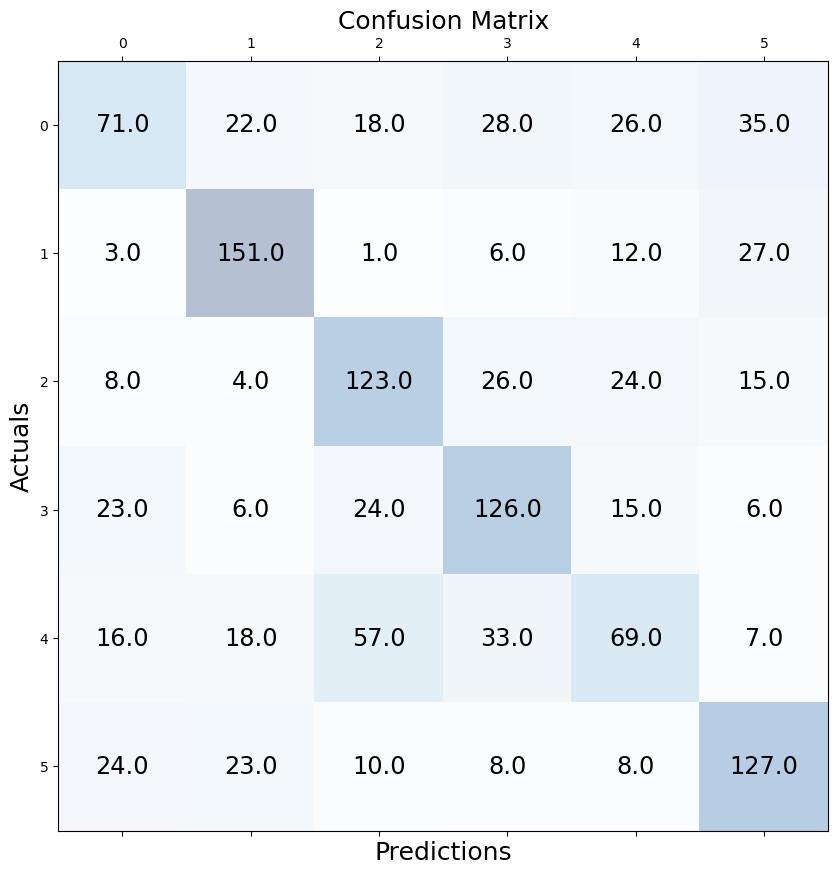

In [101]:
misclassifications = [[[] for i in range(no_of_classes)] for j in range(no_of_classes)] 
def predict(self, eg):
    scores = np.zeros( (self.no_of_classes, ))
    counts =  np.zeros( (self.no_of_classes, ))
    done = np.zeros((self.no_of_classes, self.no_of_classes))
    for i in range(self.no_of_classes):
      for j in range(self.no_of_classes):
        if (i == j or done[i][j] == 1) : continue
        done[i][j] = 1
        done[j][i] = 1
        # i is -1, j is one
        (prediction, score) = self.model[i,j].predict(eg)
        if (prediction == -1) : prediction = i
        else : prediction = j
        counts[prediction] += 1
        if (score > 0) : scores[prediction] += score
        else: scores[prediction] -= score

    # print(counts)
    max_count = np.max(counts)
    max_indices = np.where(counts == max_count)[0]
    # print(max_indices)
    max_scores = np.array([ (scores[i], i) for i in max_indices])
    # print(max_scores)
    sorted_indices = np.argsort(max_scores[:, 1])
    max_scores = max_scores[sorted_indices]
    # max_scores.sort()
    # print(max_scores)
    return (max_scores[-1, 1], max_scores[-1, 0])

def get_confusion_matrix(self, test_eg, test_ans) :
    size = test_eg.shape[0]
    confusion_matrix = np.zeros( (self.no_of_classes, self.no_of_classes))
    correct , incorrect = 0,0
    for k in range(size):
        (prediction, score) = predict(self, test_eg[k])
        # print(prediction, "\n", test_ans[k]) 
        # print("prediction is ", prediction) 
        misclassifications[test_ans[k]][int(prediction)].append(test_eg[k])  
        confusion_matrix[test_ans[k]][int(prediction)] += 1 
        if (test_ans[k] == prediction) : correct += 1
        else : incorrect +=  1

    return (confusion_matrix, (correct / (correct + incorrect)))


(confusion_matrix, accuracy) = get_confusion_matrix(multiclass_classifier, X_val_full, Y_val_full) 
print(f"accuracy is {accuracy}")
draw_confusion_matrix(confusion_matrix, "our_multiclass")

In [106]:
# visualising error images 
cnt = 0 
for img in misclassifications[4][2]:
    if (cnt > 2): break
    cnt += 1 
    img = img * 255.0
    img = img.reshape((16,16,3))
    cv2.imwrite(f"img_4_2_{cnt}.png", img)
cnt = 0 
for img in misclassifications[4][3]:
    if (cnt > 2): break
    cnt += 1 
    img = img * 255.0
    img = img.reshape((16,16,3))
    cv2.imwrite(f"img_4_3_{cnt}.png", img)
cnt = 0 
for img in misclassifications[0][3]:
    if (cnt > 2): break
    cnt += 1 
    img = img * 255.0
    img = img.reshape((16,16,3))
    cv2.imwrite(f"img_0_3_{cnt}.png", img)
cnt = 0 
for img in misclassifications[1][5]:
    if (cnt > 2): break
    cnt += 1 
    img = img * 255.0
    img = img.reshape((16,16,3))
    cv2.imwrite(f"img_1_5_{cnt}.png", img)


# resized_weight = weight * 255.0
# resized_weight = resized_weight.reshape( (16, 16, 3) )
# cv2.imwrite(f"weight_{svm_name}.png", resized_weight)

set 0 has images of houses and buildings, 1 has of forests and greenery, 2 has of ice and glaciers, 3 has of cloudy sky and mountains, 4 has of coasts and oceans,  5 of cities. 

Of these the most frequent pair of misclassified classes are (first is actual, second is prediction) : 
(4,2), (4,3), (0,3), (1,5). 
Based on the above observations, it is easy to make sense of the visualisations of the misclassified examples as showm. For eg - images of 4 and 2 both are predominantly white and blue, thus they are misclassified as each other the most. 
Similiar logic holds for 4 and 3, and so on. 

Correct : 670
Incorrect : 530
accuracy : 0.5583333333333333
accuracy is 0.5583333333333333
label with max diagonal is 1


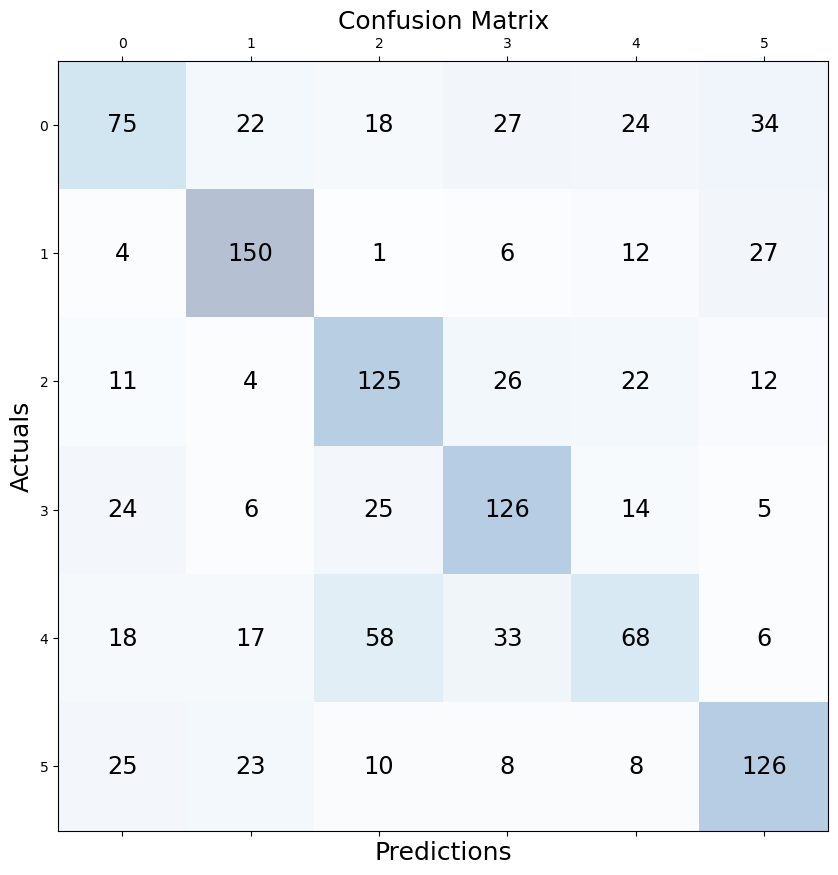

In [69]:
predictions = sk_multiclass_classifier.predict(X_val_full)
correct , incorrect = 0,0

# print(predictions.shape[0])
sk_confusion_matrix = np.array( [[0 for i in range(no_of_classes)] for j in range(no_of_classes)] ) 

for i in range(predictions.shape[0]):
  # print(predictions[i], Y_val_full[i])
  sk_confusion_matrix[Y_val_full[i]][predictions[i]] += 1
  if (predictions[i] == Y_val_full[i]): correct += 1
  else : incorrect += 1

print(f"Correct : {correct}")
print(f"Incorrect : {incorrect}")
print(f"accuracy : {correct / (correct + incorrect)}")
draw_confusion_matrix(sk_confusion_matrix, "sklearn_multiclass")


Each class has 200 samples in the validation set. The confusion matrices obtained from our implementation and from sklearn are largely similiar, differing by only a small amt. 
We also observe that class 1 is classified most correctly, whereas class 4 is the least correctly classifed class. 
The largest off diagonal entry is (4,2), which means that most misclassifications have been done for class 4 where it was confused for class 2 (58 examples). Similarly we observe that class 0 is misclassified most frequently as class 5, 1 as 5, 3 as 2, 4 as 2, 5 as 0. 



# Cross Validation

In [91]:
k = 5 
def get_splits(x,y,k):
    m = x.shape[0]
    splits = []
    for i in range(k):
        splits.append( (x[int(i*m/k) : int((i+1)*m/k)], y[int(i*m/k) : int((i+1)*m/k)]) )
    
    val_splits = [] 
    for i in range(k):
        val_split = [] 
        for j in range(k):
            if (i == j): continue
            val_split.append(splits[j]) 
        x_tup = [] 
        y_tup = []
        for s in val_split:
            x_tup.append(s[0])
            y_tup.append(s[1]) 
        x_tup = np.vstack(tuple(x_tup)) 
        y_tup = np.hstack(tuple(y_tup))
        val_splits.append((x_tup, y_tup)) 
    return (val_splits, (splits)) 

In [92]:
perm = np.random.permutation([i for i in range(X_full.shape[0])]) 
combined_x = np.zeros(X_full.shape)
combined_y = np.zeros(Y_full.shape)
for i in range(X_full.shape[0]):
    combined_x[i] = X_full[perm[i]]
    combined_y[i] = Y_full[perm[i]] 

(splits, og_splits) = get_splits(combined_x, combined_y, k)
for split in splits:
    print(split[0].shape, split[1].shape)


(11424, 768) (11424,)
(11424, 768) (11424,)
(11424, 768) (11424,)
(11424, 768) (11424,)
(11424, 768) (11424,)


In [110]:
C_arr = np.array([1e-05, 1e-03, 1, 5, 10]) 
cross_validation_ac = np.zeros(C_arr.shape)
validation_ac = np.zeros(C_arr.shape)
k = 5 
for j in range( C_arr.shape[0]):
    avg = 0 
    for i in range(k):
        correct = 0
        incorrect = 0 
        sk_model = svm.SVC(C = C_arr[j] , kernel = "rbf", gamma = 0.001) 
        sk_model.fit(splits[i][0], splits[i][1]) 
        predictions = sk_model.predict(og_splits[i][0]) 

        for w in range(og_splits[i][1].shape[0]):
            if (predictions[w] == og_splits[i][1][w]): correct += 1
            else : incorrect += 1
        print(f"for model {j} and dataset {i}, correct : {correct} and incorrect : {incorrect}") 
        accuracy = correct / (correct + incorrect) 
        avg += accuracy
    avg /= k 
    cross_validation_ac[j] = avg 
    sk_full_model = svm.SVC(C = C_arr[j] , kernel = "rbf", gamma = 0.001) 
    sk_full_model.fit(combined_x,  combined_y) 
    predictions = sk_full_model.predict(X_val_full) 
    correct = 0
    incorrect = 0
    for w in range(Y_val_full.shape[0]):
        if (predictions[w] == Y_val_full[w]): correct += 1
        else : incorrect += 1
    print(f"for model {j} validation, correct : {correct} and incorrect : {incorrect}") 
    accuracy = correct / (correct + incorrect)
    validation_ac[j] = accuracy
print(cross_validation_ac)
print(validation_ac)

for model 0 and dataset 0, correct : 463 and incorrect : 2393
for model 0 and dataset 1, correct : 437 and incorrect : 2419
for model 0 and dataset 2, correct : 462 and incorrect : 2394
for model 0 and dataset 3, correct : 462 and incorrect : 2394
for model 0 and dataset 4, correct : 454 and incorrect : 2402
for model 0 validation, correct : 482 and incorrect : 718
for model 1 and dataset 0, correct : 463 and incorrect : 2393
for model 1 and dataset 1, correct : 437 and incorrect : 2419
for model 1 and dataset 2, correct : 462 and incorrect : 2394
for model 1 and dataset 3, correct : 462 and incorrect : 2394
for model 1 and dataset 4, correct : 454 and incorrect : 2402
for model 1 validation, correct : 482 and incorrect : 718
for model 2 and dataset 0, correct : 1567 and incorrect : 1289
for model 2 and dataset 1, correct : 1571 and incorrect : 1285
for model 2 and dataset 2, correct : 1628 and incorrect : 1228
for model 2 and dataset 3, correct : 1575 and incorrect : 1281
for model 2 

In [122]:
for j in range( C_arr.shape[0]):
    correct = 0
    incorrect = 0 
    sk_model = svm.SVC(C = C_arr[j] , kernel = "rbf", gamma = 0.001) 
    sk_model.fit(X_full, Y_full) 
    predictions = sk_model.predict(X_val_full)
    for w in range(Y_val_full.shape[0]):
        if (predictions[w] == Y_val_full[w]): correct += 1
        else : incorrect += 1
    print(f"for model {j} on full dataset, correct : {correct} and incorrect : {incorrect}") 
    accuracy = correct / (correct + incorrect) 
    

for model 0 on full dataset, correct : 482 and incorrect : 718
for model 1 on full dataset, correct : 482 and incorrect : 718
for model 2 on full dataset, correct : 670 and incorrect : 530
for model 3 on full dataset, correct : 711 and incorrect : 489
for model 4 on full dataset, correct : 730 and incorrect : 470


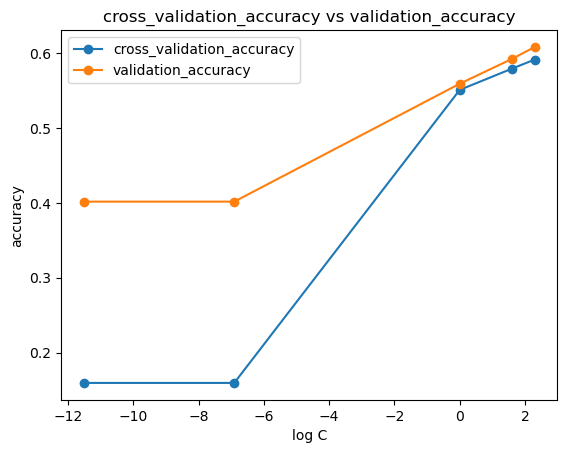

In [119]:

def plot_line(x, y, xlabel, ylabel, title):
    plt.plot(x, y, marker='o', label = title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.title(title)
    # plt.savefig(f"{name}.png")
    # plt.show()

plot_line( np.log(C_arr), cross_validation_ac, "log C", "accuracy", "cross_validation_accuracy")
plot_line( np.log(C_arr), validation_ac, "log C", "accuracy", "validation_accuracy") 
plt.title("cross_validation_accuracy vs validation_accuracy")
plt.legend()
plt.savefig("cross_validation_accuracy vs validation_accuracy.png")
plt.show()



We observe that the value of C which gives the best cross validation accuracy is also the same which gives the
best validation accuracy. 
In fact as the cross validation accuracy (CVA) increases, the validation accuracy (VA) also increases with C. 

Thus cross validation accuracy serves as a good measure of the generalized accuracy, i.e we can say for our case that if a model with C = C1 has better cross validation accuracy than model with C = C2, then its generalized accuracy is also expected to be better.